# Train a neural network for segmenting a single corrupted image. The only information is high-level image knowledge. No labels or pretrained network were used.

This script runs faster when using multiple BLAS Threads and Julia Threads. Further speedups are possible if the network forward and backward propagation are computed by a GPU (this script is CPU by default) and the the parallel computation of the projection onto the Generalized Minkowski Set is activated, which requires 7 julia workers.

Load packages and image, introduce corruption

In [1]:
using PyPlot
using Images
using TestImages
using LinearAlgebra
using Random
using Statistics
using Printf
using SetIntersectionProjection
using InvertibleNetworks #(https://github.com/slimgroup/InvertibleNetworks.jl)
using Flux
import Flux.Optimise.update!

image = load("images/zebra2.jpg")
image = channelview(image)
image = convert(Array{Float32,3},image)
image = permutedims(image,[2 3 1])

image=image[1:2:end,1:2:end,:]

#corrupt image (missing pixels)
percentage_missing = 0.10
inds = CartesianIndices((size(image,1),size(image,2)))
inds = shuffle(inds)
inds = inds[1:round(Int,length(inds)*percentage_missing)]
image[inds,:,:] .= 0

#corrupt image (missing lines)
# inds = randperm(size(image,1))
# inds = inds[1:round(Int,length(inds)*0.10)]
# image[inds,:,:,:] .= 0

#make image 9 channels
image=repeat(image,outer=[1,1,3,1]);

In [2]:
#PARSDMM options:
options=PARSDMM_options()
options.FL=Float32
options.adjust_gamma           = true
options.adjust_rho             = true
options.adjust_feasibility_rho = true
options.Blas_active            = true
options.maxit                  = 700

options.feas_tol     = 0.001#0.0001
options.obj_tol      = 0.001#0.0001
options.evol_rel_tol = 0.0001#0.00001
set_zero_subnormals(true)
BLAS.set_num_threads(4)

Set up the Generalized minkowski constraint. There is one such constraint per class (network output channel). The sets use information about the size of the object, a bounding box as bound constraints, and describes the object as a simple 'body' using a sum of monotonically increasing and decreasing images in horizontal and vertical directions.

In [3]:
################## set up Generalized Minkowski constriants################
################## set up Generalized Minkowski constriants################
mutable struct compgrid
  d :: Tuple
  n :: Tuple
end

P         = Vector{Any}(undef, 1) #allocate vector of Projectors (just one in this case because there is one examle)
P[1]      = Vector{Any}(undef, 2)
n         = size(image[:,:,1,1])
comp_grid = compgrid((1.0,1.0),(n[1], n[2]))

for j=1:2 #loop over active output channels (classes)
  if j==1
######## Channel 1 ############################

    #constraints for total model
    constraint_sum = Vector{SetIntersectionProjection.set_definitions}()

    #cardinality:
    m_min     = 0
    m_max     = round(Int,0.25*prod(n[1:2]))
    set_type  = "cardinality"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #bounds:
    m_min     = zeros(Float32,n[1],n[2])
    m_max     = ones(Float32,n[1],n[2])
    m_max[1:20,:] .= 0f0;m_max[end-20:end,:] .= 0f0;m_max[:,1:20] .= 0f0;m_max[:,end-20:end] .= 0f0;
    m_min = vec(m_min)
    m_max = vec(m_max)
    set_type  = "bounds"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #constraints for component 1 of the model
    constraint_c1 = Vector{SetIntersectionProjection.set_definitions}()

    #bounds component 1:
    m_min     = -1f0
    m_max     = 1f0
    set_type  = "bounds"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    # #slope constraints component 1(horizontal)
    m_min     = 0.0
    m_max     = 1e6
    set_type  = "bounds"
    TD_OP     = "D_x"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #constraints for component 2 of the model
    constraint_c2 = Vector{SetIntersectionProjection.set_definitions}()

    #bounds component 2:
    m_min     = -1.0f0
    m_max     = 1.0f0
    set_type  = "bounds"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #slope constraints component 2(horizontal)
    m_min     = -1e6
    m_max     = 0.0
    set_type  = "bounds"
    TD_OP     = "D_x"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))


    (P_sub_sum,TD_OP_sum,set_Prop_sum) = setup_constraints(constraint_sum,comp_grid,options.FL)
    (P_sub_c1,TD_OP_c1,set_Prop_c1) = setup_constraints(constraint_c1,comp_grid,options.FL)
    (P_sub_c2,TD_OP_c2,set_Prop_c2) = setup_constraints(constraint_c2,comp_grid,options.FL)

    options.parallel  = false
    options.Minkowski = true
    (TD_OP,set_Prop,AtA,l,y) = PARSDMM_precompute_distribute_Minkowski(TD_OP_c1,TD_OP_c2,TD_OP_sum,set_Prop_c1,set_Prop_c2,set_Prop_sum,comp_grid,options)

    P_sub = deepcopy(P_sub_c1);
    append!(P_sub,P_sub_c2)
    append!(P_sub,P_sub_sum)

    options.zero_ini_guess=true

    function temp_func1(x,AtA,TD_OP,set_Prop,P_sub,comp_grid,options)
        sx = size(x)
        (x,log_PARSDMM) = PARSDMM(vec(x),AtA,TD_OP,set_Prop,P_sub,comp_grid,options);
        x = x[1:Int(length(x)/2)]+x[1+Int(length(x)/2):end]
        x = reshape(x,sx)
        return x
    end
    P[1][1] = x -> temp_func1(x,AtA,TD_OP,set_Prop,P_sub,comp_grid,options)

  elseif j==2
    ######## Channel 2 ############################

    #constraints for total model\
    constraint_sum = Vector{SetIntersectionProjection.set_definitions}()

    #cardinality:
    m_min     = 0
    m_max     = round(Int,0.95*prod(n[1:2]))
    set_type  = "cardinality"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #bounds:
    m_min     = zeros(Float32,n[1],n[2])
    m_min[1:20,:] .= 1f0;m_min[end-20:end,:] .= 1f0;m_min[:,1:20] .= 1f0;m_min[:,end-20:end] .= 1f0;
    m_max     = ones(Float32,n[1],n[2])
    #m_max[bound_idx_pos] .= 0f0
    #m_min[bound_idx_neg] .= 1f0
    m_min = vec(m_min)
    m_max = vec(m_max)
    set_type  = "bounds"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_sum, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #constraints for component 1 of the model
    constraint_c1 = Vector{SetIntersectionProjection.set_definitions}()

    #bounds component 1:
    m_min     = -1f0
    m_max     = 1f0
    set_type  = "bounds"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #slope constraints component 1(horizontal)
    m_min     = 0.0
    m_max     = 1e6
    set_type  = "bounds"
    TD_OP     = "D_x"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c1, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #constraints for component 2 of the model
    constraint_c2 = Vector{SetIntersectionProjection.set_definitions}()

    #bounds component 2:
    m_min     = -1.0
    m_max     = 1.0
    set_type  = "bounds"
    TD_OP     = "identity"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    #slope constraints component 2(horizontal)
    m_min     = -1e6
    m_max     = 0.0
    set_type  = "bounds"
    TD_OP     = "D_x"
    app_mode  = ("matrix","")
    custom_TD_OP = ([],false)
    push!(constraint_c2, set_definitions(set_type,TD_OP,m_min,m_max,app_mode,custom_TD_OP))

    (P_sub_sum,TD_OP_sum,set_Prop_sum) = setup_constraints(constraint_sum,comp_grid,options.FL)
    (P_sub_c1,TD_OP_c1,set_Prop_c1) = setup_constraints(constraint_c1,comp_grid,options.FL)
    (P_sub_c2,TD_OP_c2,set_Prop_c2) = setup_constraints(constraint_c2,comp_grid,options.FL)

    options.parallel  = false
    options.Minkowski = true
    (TD_OP,set_Prop,AtA,l,y) = PARSDMM_precompute_distribute_Minkowski(TD_OP_c1,TD_OP_c2,TD_OP_sum,set_Prop_c1,set_Prop_c2,set_Prop_sum,comp_grid,options)

    P_sub = deepcopy(P_sub_c1);
    append!(P_sub,P_sub_c2)
    append!(P_sub,P_sub_sum)

    options.zero_ini_guess=true

    function temp_func2(x,AtA,TD_OP,set_Prop,P_sub,comp_grid,options)
        sx = size(x)
        (x,log_PARSDMM) = PARSDMM(vec(x),AtA,TD_OP,set_Prop,P_sub,comp_grid,options);
        x = x[1:Int(length(x)/2)]+x[1+Int(length(x)/2):end]
        x = reshape(x,sx)
        return x
    end

    P[1][2] = x -> temp_func2(x,AtA,TD_OP,set_Prop,P_sub,comp_grid,options)
  end
end

################## End setup Generalized Minkowski constraints ################

Use a reversible hyperbolic network

In [4]:
#set up neural network

#12 layers with 9 channels each for a reversible hyperbolic network
architecture = ((0, 9), (0, 9),(0, 9),(0, 9),(0, 9),(0, 9),(0, 9),(0, 9),(0, 9),(0, 9),(0, 9),(0, 9))

k = 3   # kernel size
s = 1   # stride
p = 1   # padding
n_chan_in = size(image,3)
(nx, ny)  = size(image)[1:2]
α         = 0.3^2
batchsize = 1
HN = H = NetworkHyperbolic(n_chan_in, architecture; α)

#Test reversibility: neural network forward prop -> inverse prop
X_prev, X_curr, lgdet = HN.forward(deepcopy(image),deepcopy(image))
Y_curr_rec, Y_new_rec = HN.inverse(X_prev, X_curr)
norm(vec(Y_curr_rec)-vec(image))./norm(vec(image)) #should be very small number

4.103121f-7

Set up the squared point-to-set distance function to measure the distance to the Generalized Minkowski set, and compute the gradient of this distance function.

In [5]:
#squared distance function to a constraint set
function Dist2ToSet(input,P,active_channels,example_ind)

  #initialize some stuff
  size_input = size(input)
  pen_grad   = zeros(Float32,size(input))
  pen_value  = 0f0

  #use softmax of final network state for constraining
  #the output for segmentation problems (don't use softmax for non-linear regression)
  input      = softmax(input[:,:,active_channels,:],dims=3)

  for j in active_channels #loop over channels, each channel has a (different) corresponding projector
    input_slice        = input[:,:,j,1]
    pen_value_slice    = 0f0 #
    P_input            = P[example_ind][j](input_slice) #project onto constraint set (can be an intersection)
    pen_value_slice    = 0.5f0*norm(vec(P_input)-vec(input_slice))^2 #squared point-to-set distance functino
    pen_grad[:,:,j,1] .= input_slice .- P_input # gradient of point-to-set distance function

    pen_value = pen_value + pen_value_slice #accumulate penalty value (loss) over channels
  end #end channels loop

  #at this point,the softmax of the network output has been projected onto the intersection. Now we need to 'complete' the gradient
  #via the last part of the chain-rule for distance-function-squared and softmax
  pen_grad[:,:,active_channels,1] .= ∇softmax(pen_grad[:,:,active_channels,1], input[:,:,active_channels,1]; dims=3)

  return pen_value, pen_grad
end

Dist2ToSet (generic function with 1 method)

Set up the loss function. This function includes the forward propagation of the image through the network, computes the gradient of the distance function, then backpropagates and collects the gradient w.r.t. the network parameters (not explicitly visible in the code below). Returns the squared point-to-set-distance value attaches the gradient w.r.t. to the network parameters to HN

In [6]:
#loss function
function loss(HN, X0, X1,P,active_channels,flip_dims)

  #(optionally) augment
  X0_augment = deepcopy(X0)
  for i in flip_dims
    if rand() > 0.5
      X0_augment = reverse(X0_augment,dims=i)
    end
  end

  #forward prop through the network
  Y_curr, Y_new, lgdet = HN.forward(X0_augment, X0_augment)

  #copmute squared distance function value and gradient
  dc2,dc2_grad = Dist2ToSet(Y_new,P,active_channels,1)

  #backpropagation through the network to obtain the gradient w.r.t. the network parameters
  ΔY_curr  = dc2_grad
  ΔY_new = zeros(Float32,size(dc2_grad))
  ΔY_curr, ΔY_new, Y_curr, Y_new = HN.backward(ΔY_curr, ΔY_new, Y_curr, Y_new)

  return dc2
end

loss (generic function with 1 method)

Training loop to update the network parameters

In [7]:
#training loop function
function train(HN,X0,X1,P,active_channels,flip_dims,maxiter,opt)
  fval        = zeros(Float32, maxiter)

  for j=1:maxiter

    # Evaluate objective and gradients
    fval[j] = loss(HN, X0, X1,P,active_channels,flip_dims)
    mod(j, 1) == 0 && (print("Iteration: ", j, "; f = ", fval[j], "\n"))

    # Update network params
    counter = 1
    for p in get_params(HN)
      update!(opt, p.data, p.grad)
    end
    clear_grad!(HN)

  end

  return fval
end

train (generic function with 1 method)

Train network. Start with data augmentation and larger learning rate. Then reduce learning rate and stop data augmentation.

In [ ]:
#training and optimization settings
maxiter         = 30
opt             = Flux.ADAM(1f-2)
active_channels = [1,2]
flip_dims       = [1,2]
fval = train(HN,image,image,P,active_channels,flip_dims,maxiter,opt)

opt   = Flux.ADAM(1f-3)
fval2 = train(HN,image,image,P,active_channels,flip_dims,maxiter,opt)

maxiter   = 160
flip_dims = []
fval3     = train(HN,image,image,P,active_channels,flip_dims,maxiter,opt)

maxiter = 30
opt     = Flux.ADAM(1f-4)
fval4   = train(HN,image,image,P,active_channels,flip_dims,maxiter,opt)

Plot the results

non-convex set(s) involved, using special settings
stationary objective and reached feasibility, exiting PARSDMM (iteration 156)
non-convex set(s) involved, using special settings


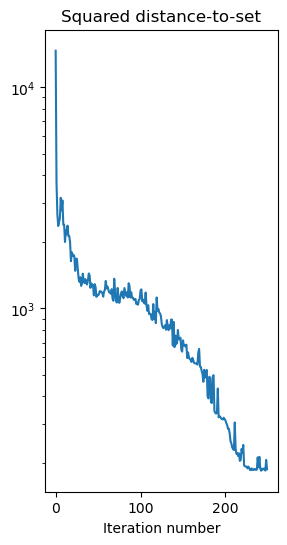

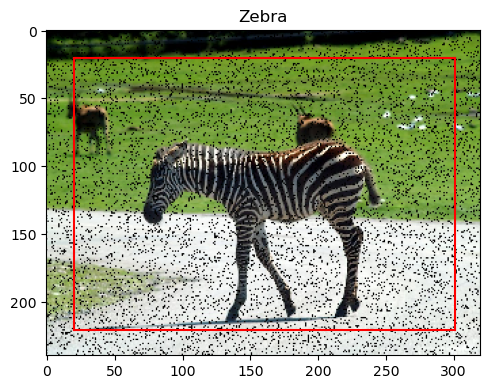

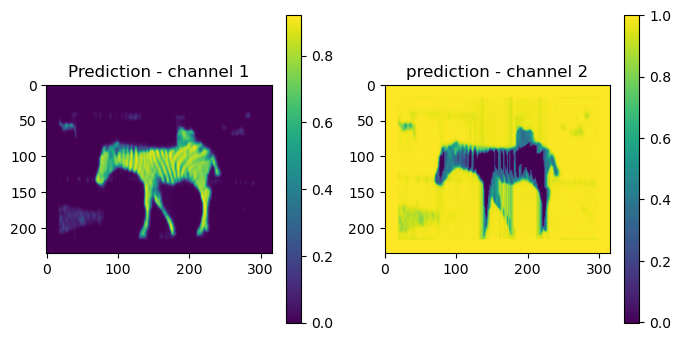

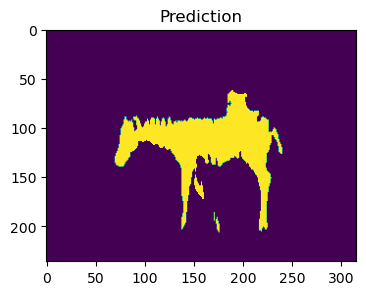

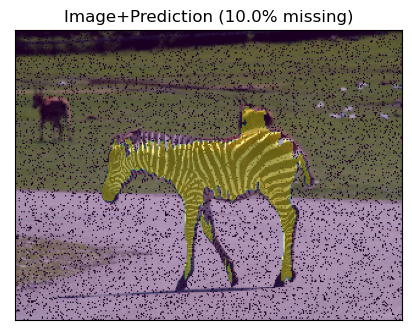

stationary objective and reached feasibility, exiting PARSDMM (iteration 150)


In [9]:
fval_total = vcat(fval,fval2,fval3,fval4)

figure(figsize=(3,6));semilogy(fval_total);title("Squared distance-to-set");
xlabel("Iteration number");
savefig("loss_zebra.png")

#Plot data with bounding box
n=size(image)
figure(figsize=(5,4))
imshow(image[:,:,1:3,1])
plot([20,20],[20,n[1]-19],"r") #up-down left
plot([n[2]-19,n[2]-19],[20,n[1]-19],"r") #up_down right
plot([20,n[2]-19],[20,20],"r") #left-right up
plot([20,n[2]-19],[n[1]-19,n[1]-19],"r") #left-right down
title("Zebra")
tight_layout()
savefig("data_zebra.png")

#predict using trained network
~, prediction, ~ = HN.forward(deepcopy(image),deepcopy(image))
prediction[:,:,1:2,1] .= softmax(prediction[:,:,1:2,1],dims=3);

#project results on Generalized Minkowski set
project_channel_1 = P[1][1](vec(deepcopy(prediction[:,:,1,1])));
project_channel_2 = P[1][2](vec(deepcopy(prediction[:,:,2,1])));
project_channel_1 = reshape(project_channel_1,comp_grid.n[1],comp_grid.n[2])
project_channel_2 = reshape(project_channel_2,comp_grid.n[1],comp_grid.n[2])

vmi = 0.0
vma = 1.0
figure(figsize=(8,4))
subplot(1,2,1);imshow(Array(project_channel_1)[3:end-2,3:end-2]);PyPlot.title("Prediction - channel 1");colorbar()
subplot(1,2,2);imshow(Array(project_channel_2)[3:end-2,3:end-2]);PyPlot.title("prediction - channel 2");colorbar()
savefig("prediction_zebra_channels.png")

#thresholded prediction
pred_thres = zeros(Int,size(prediction)[1:2])
pos_inds   = findall(project_channel_1 .> project_channel_2)
pred_thres[pos_inds] .= 1

figure(figsize=(4,4));
imshow(Array(pred_thres)[3:end-2,3:end-2],vmin=vmi,vmax=vma);PyPlot.title("Prediction");
savefig("prediction_zebra.png")

#Plot data+prediction
figure(figsize=(5,4))
imshow(Array(pred_thres)[2:end-1,2:end-1])
imshow(image[2:end-1,2:end-1,1:3],alpha=0.6)
ax = gca()
ax[:xaxis][:set_visible](false)
ax[:yaxis][:set_visible](false)
title(string("Image+Prediction (",100*percentage_missing,"% missing)"))
savefig("data_plus_pred.png")